<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
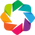

In [1]:
from utils_behavior import Sleap_utils
from utils_behavior import HoloviewsTemplates
from utils_behavior import HoloviewsPlots
from utils_behavior import Utils
from utils_behavior import Processing

from utils_behavior import Ballpushing_utils


import importlib

from pathlib import Path

import json

from matplotlib import pyplot as plt
import pandas as pd
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import seaborn as sns
from shiny import App, Inputs, Outputs, Session, reactive, render, req, ui



#import lux

import pandas as pd

#lux.config.set_executor_type("Pandas")

import numpy as np
import h5py
import re

In [8]:
importlib.reload(Ballpushing_utils)

<module 'utils_behavior.Ballpushing_utils' from '/home/durrieu/utils_behavior/utils_behavior/Ballpushing_utils.py'>

In [2]:
Datapath = Path("/mnt/upramdya_data/MD/F1_Tracks/Videos")

# Look for video folders and load Fly objects

# videos = list(Datapath.rglob("*.mp4"))

# Flies = []

# for video in videos:
#     fly = Ballpushing_utils.Fly(video.parent)
    
#     Flies.append(fly)

# For each directory in the datapath, load the Experiment object
Experiments = []

for exp in Datapath.iterdir():
    if exp.is_dir():
        experiment = Ballpushing_utils.Experiment(exp, experiment_type="F1")
        Experiments.append(experiment)

Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena2/Right
F1 has no particular time range.
Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena2/Left
F1 has no particular time range.
Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena7/Right
F1 has no particular time range.
Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena7/Left
F1 has no particular time range.
Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena6/Right
F1 has no particular time range.
Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena6/Left
F1 has no particular time range.
Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Videos/240924_F1_3mm_ends_Videos_Checked/arena5/Right
F1 has no particular time range.
Loading fly from /mnt/upramdya_data/MD/F1_Tracks/Vi

In [84]:
importlib.reload(Ballpushing_utils)

<module 'utils_behavior.Ballpushing_utils' from '/home/durrieu/utils_behavior/utils_behavior/Ballpushing_utils.py'>

In [85]:
Data_F1 = Ballpushing_utils.Dataset(Experiments)

str(Data_F1)

'Dataset with 249 flies and 14 experiments\nkeyword: F1, 3mm, ends'

In [119]:
Data_F1_coordinates = Data_F1.generate_dataset("F1_coordinates")

Fly 240924_F1_3mm_ends_Videos_Checked_arena2_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena7_Right never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena7_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena6_Right never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena6_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena8_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena4_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena9_Right never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena9_Left never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena6_Right never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena6_Left never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena8_Left never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena3_Right never exits the corridor
Fly 240919_F1_3mm_en

In [106]:
Data_F1_coordinates["fly"].nunique()

191

In [88]:
Data_F1_coordinates.head()

,index,time,frame,adjusted_time,training_ball,test_ball,fly,flypath,experiment,Nickname,...,Orientation,Pretraining,Unlocked,,F1_condition,FeedingState,Light,Crossing,Balltype,EndChamber
0,0,0.034483,1,-6929.310345,0.000000,0.000000,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
1,145,5.034483,146,-6924.310345,0.083613,0.545304,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
2,290,10.034483,291,-6919.310345,0.110490,0.436878,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
3,435,15.034483,436,-6914.310345,0.127412,0.689270,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
4,580,20.034483,581,-6909.310345,0.099548,0.710870,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN


In [120]:
# Keep only data where adjusted time is >= 0

Data_F1_coordinates = Data_F1_coordinates[Data_F1_coordinates["adjusted_time"] >= 0]

Data_F1_coordinates = Data_F1_coordinates[Data_F1_coordinates["adjusted_time"] <= 2700]

In [90]:
Data_F1_coordinates.head()

,index,time,frame,adjusted_time,training_ball,test_ball,fly,flypath,experiment,Nickname,...,Orientation,Pretraining,Unlocked,,F1_condition,FeedingState,Light,Crossing,Balltype,EndChamber
1386,200970,6930.034483,200971,0.689655,158.397869,1.380524,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
1387,201115,6935.034483,201116,5.689655,158.406349,0.444439,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
1388,201260,6940.034483,201261,10.689655,158.406800,8.258391,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
1389,201405,6945.034483,201406,15.689655,158.409642,10.722712,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN
1390,201550,6950.034483,201551,20.689655,158.438254,10.757913,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,...,std,y,nn,,pretrained,NaN,NaN,NaN,NaN,NaN


In [121]:
# Smooth high frequency noise in the data

Data_F1_coordinates["test_ball_smooth"] = Data_F1_coordinates["test_ball"].rolling(window=10, min_periods=1).mean()

In [56]:
# Save the dataset to a csv file

Data_F1_coordinates.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Dataset.csv")

In [92]:
Data_Avg = Data_F1_coordinates.groupby(["F1_condition", "time"]).mean("test_ball").reset_index()

# Data_Avg["test_ball_smooth"] = Processing.savgol_lowpass_filter(
#     Data_Avg["test_ball"], window_length=221, polyorder=1
# )

Data_Avg


,F1_condition,time,index,frame,adjusted_time,training_ball,test_ball,test_ball_smooth
0,control,25.034483,725.0,726.0,4.724138,NaN,0.056593,42.824762
1,control,30.034483,870.0,871.0,9.724138,NaN,0.113875,38.080926
2,control,35.034483,1015.0,1016.0,6.586207,NaN,0.312282,30.437677
3,control,40.034483,1160.0,1161.0,11.586207,NaN,0.303041,26.502084
4,control,45.034483,1305.0,1306.0,16.586207,NaN,0.488538,22.592129
...,...,...,...,...,...,...,...,...
4563,pretrained_unlocked,8980.034483,260420.0,260421.0,5154.649246,189.691264,42.261823,43.800451
4564,pretrained_unlocked,8985.034483,260565.0,260566.0,5159.649246,196.429355,44.843594,43.590592
4565,pretrained_unlocked,8990.034483,260710.0,260711.0,5164.649246,193.849172,42.392246,43.308345
4566,pretrained_unlocked,8995.034483,260855.0,260856.0,5169.649246,194.023592,46.173881,43.401970


In [122]:
# Identify the time at which adjusted time is 0 for each fly
zero_adjusted_time = Data_F1_coordinates.groupby('fly').apply(lambda df: df.loc[df['adjusted_time'].abs().idxmin(), 'time']).reset_index()
zero_adjusted_time.columns = ['fly', 'zero_time']

# Merge the zero_adjusted_time with the original DataFrame
Data_F1_coordinates = Data_F1_coordinates.merge(zero_adjusted_time, on='fly')

# Shift the time values
Data_F1_coordinates['shifted_time'] = Data_F1_coordinates['time'] - Data_F1_coordinates['zero_time']

In [131]:
# make a rounded adjusted time column where the time is rounded to the nearest 10 seconds

#Data_F1_coordinates["rounded_adjusted_time"] = Data_F1_coordinates["adjusted_time"].round(-1)

# Round adjusted time values to the nearest 10 seconds
Data_F1_coordinates['rounded_adjusted_time'] = (Data_F1_coordinates['adjusted_time'] / 10).round() * 10

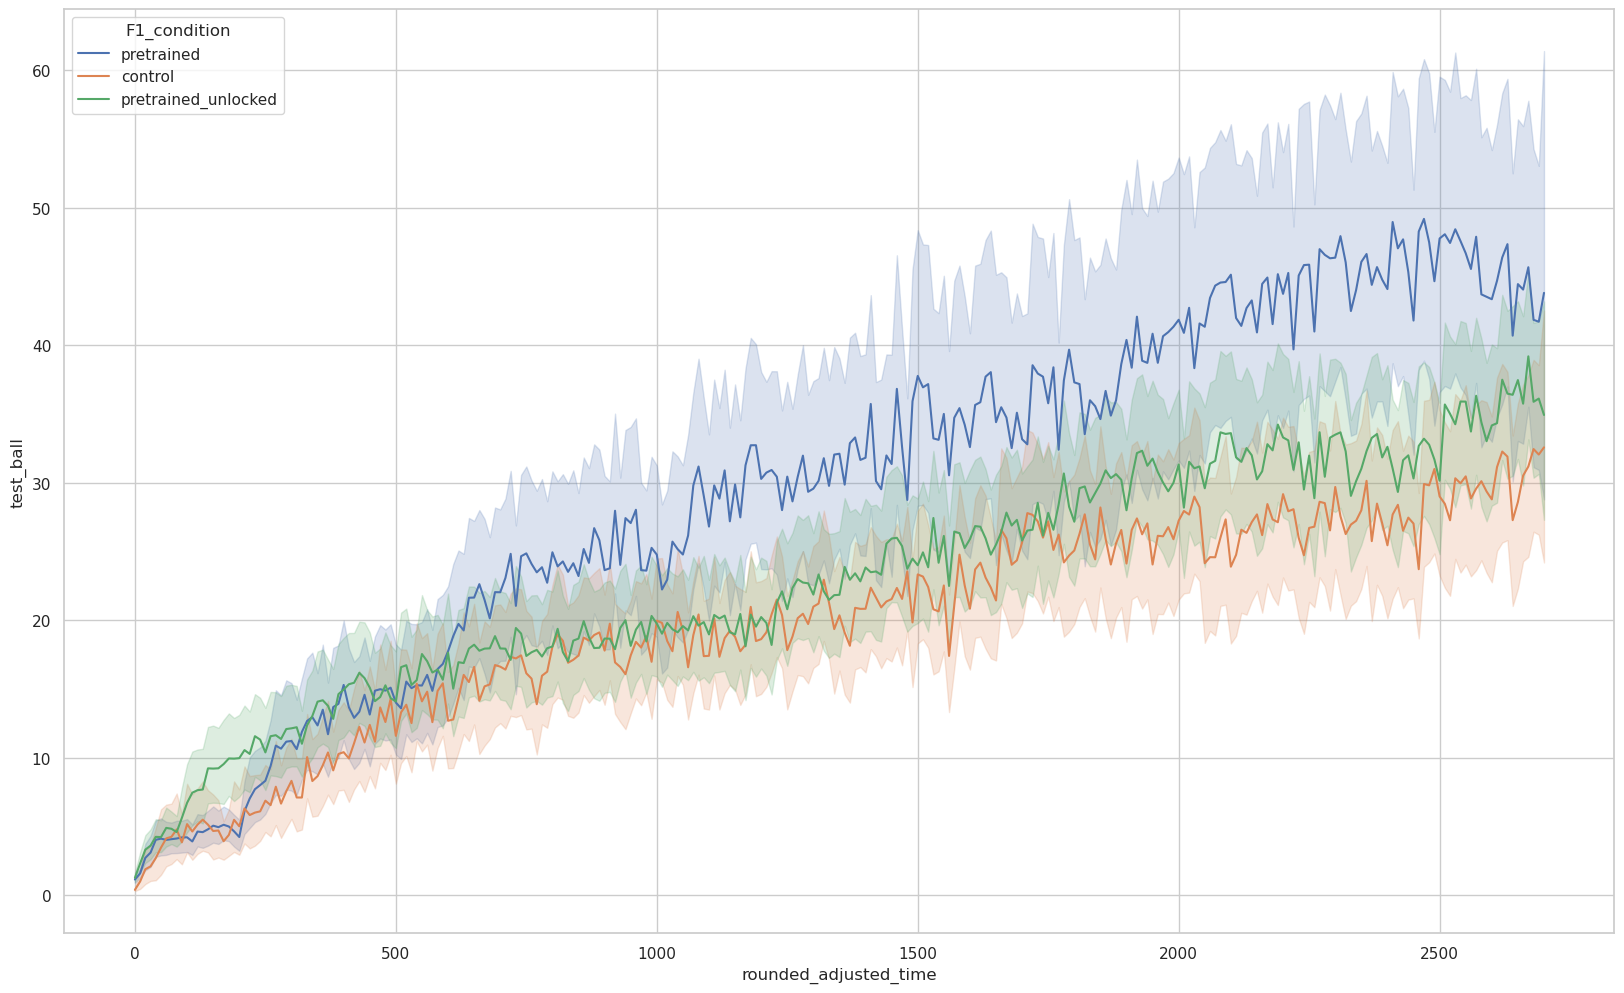

In [133]:
Lineplot = sns.lineplot(data=Data_F1_coordinates, x="rounded_adjusted_time", y="test_ball", hue="F1_condition")

plt.savefig(f"{plot_savepath}/241128_F1_Lineplot.png")

plt.show()

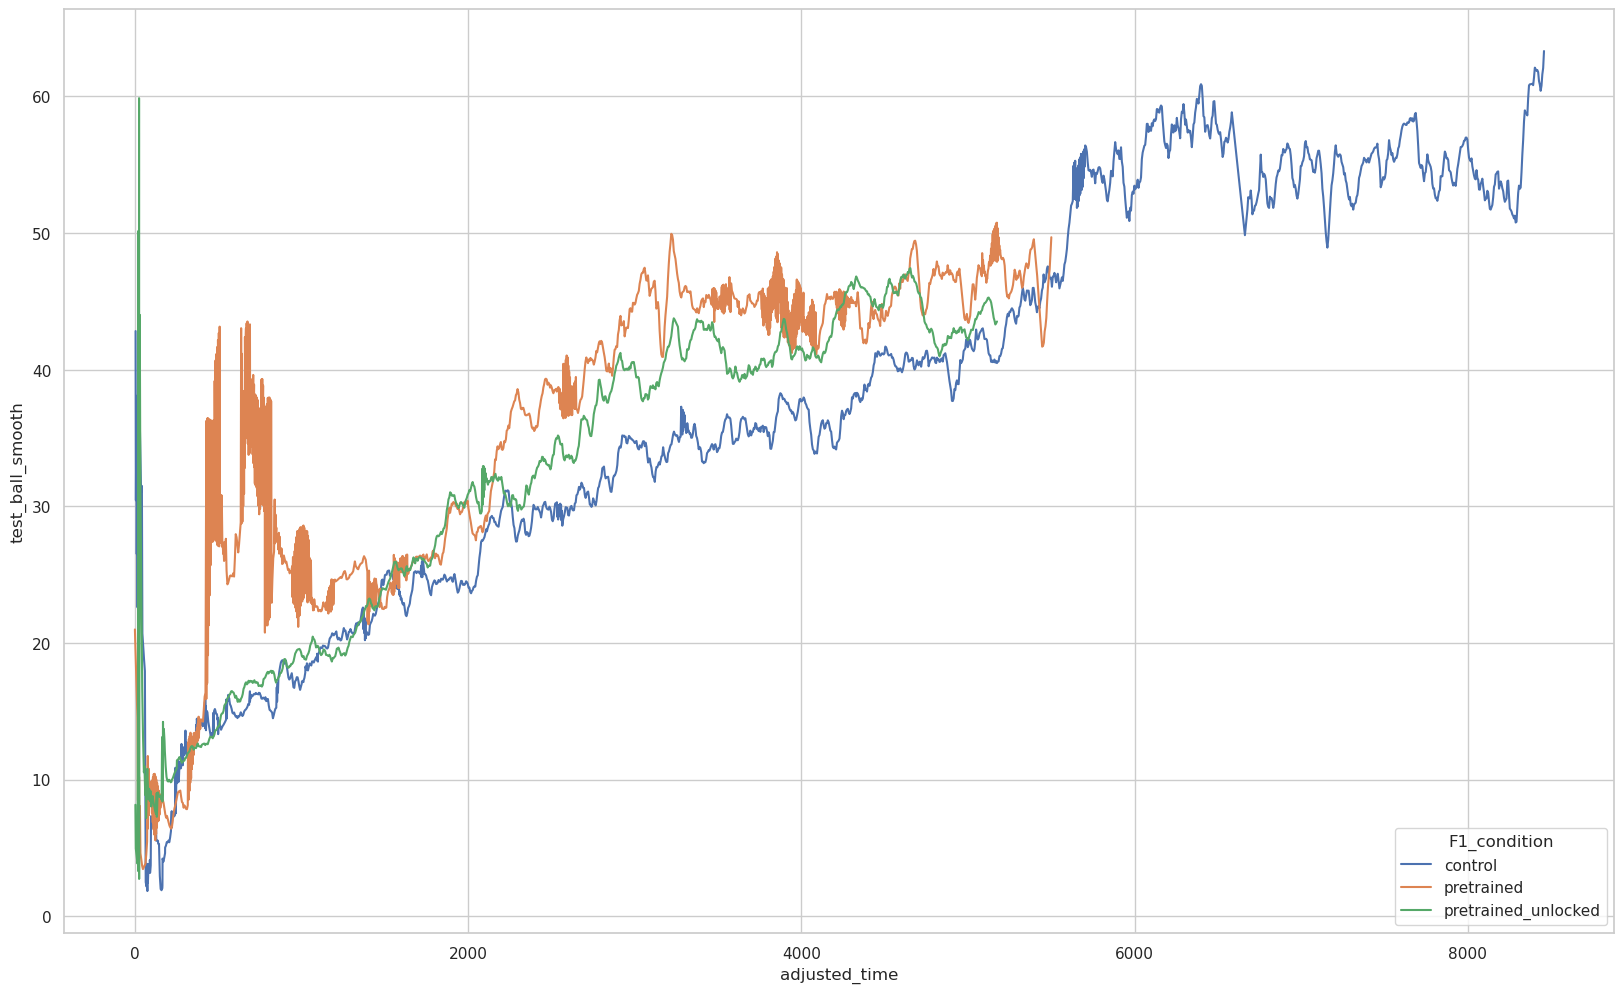

In [95]:
# Plot the average test ball distance grouped by condition over adjusted time with adjusted time starting at 0

sns.lineplot(data=Data_Avg, x="adjusted_time", y="test_ball_smooth", hue="F1_condition", ci="sd")

# Add the 95% confidence interval

#plt.fill_between(Data_Avg["adjusted_time"], Data_Avg["smoothed_test_ball_upper"], Data_Avg["smoothed_test_ball_lower"], alpha=0.3)

plt.show()

# Exploring the metrics

In [7]:
Data_metrics  = Data_F1.generate_dataset("summary")

In [8]:
Data_metrics.head()

,index,nb_events,max_event,max_event_time,max_distance,final_event,final_event_time,nb_significant_events,significant_ratio,first_significant_event,...,Pretraining,Unlocked,,F1_condition,ball_condition,FeedingState,Light,Crossing,Balltype,EndChamber
0,fly_0_ball_0,3.174903,18.0,7969.586207,189.631525,17.0,7799.965517,0.288628,0.090909,2.0,...,y,nn,,pretrained,training,NaN,NaN,NaN,NaN,NaN
1,fly_0_ball_1,9.174923,8.0,922.551724,22.370083,NaN,NaN,0.482891,0.052632,8.0,...,y,nn,,pretrained,test,NaN,NaN,NaN,NaN,NaN
2,fly_0_ball_0,5.777645,49.0,8558.931034,73.194067,NaN,NaN,0.222217,0.038462,24.0,...,y,nn,,pretrained,training,NaN,NaN,NaN,NaN,NaN
3,fly_0_ball_1,0.000000,NaN,NaN,1.872002,NaN,NaN,0.000000,NaN,NaN,...,y,nn,,pretrained,test,NaN,NaN,NaN,NaN,NaN
4,fly_0_ball_0,11.666398,34.0,2427.862069,44.008828,NaN,NaN,0.111109,0.009524,33.0,...,y,nn,,pretrained,training,NaN,NaN,NaN,NaN,NaN


In [9]:
# Save the dataset to a csv file

Data_metrics.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Summary.csv")

In [ ]:
# Load the dataset from the csv file

Data_metrics = pd.read_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241115_F1_Summary.csv")

In [ ]:
Data_metrics

In [10]:
Data_metrics.columns

Index(['index', 'nb_events', 'max_event', 'max_event_time', 'max_distance',
       'final_event', 'final_event_time', 'nb_significant_events',
       'significant_ratio', 'first_significant_event',
       'first_significant_event_time', 'aha_moment', 'aha_moment_time',
       'insight_effect', 'cumulated_breaks_duration', 'pushed', 'pulled',
       'pulling_ratio', 'success_direction', 'interaction_proportion',
       'distance_moved', 'exit_time', 'direction_match', 'fly', 'flypath',
       'experiment', 'Nickname', 'Brain region', 'Date', 'Genotype', 'Period',
       'Peak', 'Orientation', 'Pretraining', 'Unlocked', '', 'F1_condition',
       'ball_condition', 'FeedingState', 'Light', 'Crossing', 'Balltype',
       'EndChamber'],
      dtype='object')

In [11]:
# Plot the pulling ratio for training as x and for test as y, colored by F1 condition

# Data_Training = Data_metrics[(Data_metrics["F1_condition"] != "control") & (Data_metrics["ball_condition"] == "training")]
# Data_Test = Data_metrics[(Data_metrics["F1_condition"] != "control") & (Data_metrics["ball_condition"] == "test")]

Data_Training = Data_metrics[(Data_metrics["ball_condition"] == "training")]
Data_Test = Data_metrics[(Data_metrics["ball_condition"] == "test")]

merged = Data_Training.merge(Data_Test, on="fly")

In [12]:
merged

,index_x,nb_events_x,max_event_x,max_event_time_x,max_distance_x,final_event_x,final_event_time_x,nb_significant_events_x,significant_ratio_x,first_significant_event_x,...,Pretraining_y,Unlocked_y,_y,F1_condition_y,ball_condition_y,FeedingState_y,Light_y,Crossing_y,Balltype_y,EndChamber_y
0,fly_0_ball_0,3.174903,18.0,7969.586207,189.631525,17.0,7799.965517,0.288628,0.090909,2.0,...,y,nn,,pretrained,test,NaN,NaN,NaN,NaN,NaN
1,fly_0_ball_0,5.777645,49.0,8558.931034,73.194067,NaN,NaN,0.222217,0.038462,24.0,...,y,nn,,pretrained,test,NaN,NaN,NaN,NaN,NaN
2,fly_0_ball_0,11.666398,34.0,2427.862069,44.008828,NaN,NaN,0.111109,0.009524,33.0,...,y,nn,,pretrained,test,NaN,NaN,NaN,NaN,NaN
3,fly_0_ball_0,6.666513,34.0,4948.137931,56.660357,NaN,NaN,0.555543,0.083333,1.0,...,y,nn,,pretrained,test,NaN,NaN,NaN,NaN,NaN
4,fly_0_ball_0,12.777484,106.0,8598.448276,101.163921,NaN,NaN,1.999954,0.156522,11.0,...,y,nn,,pretrained,test,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,fly_0_ball_0,13.333014,70.0,4182.068966,24.411444,NaN,NaN,0.833313,0.062500,24.0,...,y,nn,NaN,pretrained,test,starved_noWater,on,NaN,NaN,3mm
161,fly_0_ball_0,17.777352,35.0,2105.862069,123.888806,NaN,NaN,4.166567,0.234375,8.0,...,y,nn,NaN,pretrained,test,starved_noWater,on,NaN,NaN,3mm
162,fly_0_ball_0,6.666507,7.0,1497.034483,37.525346,NaN,NaN,0.000000,0.000000,None,...,y,nn,NaN,pretrained,test,starved_noWater,on,NaN,NaN,3mm
163,fly_0_ball_0,11.388616,72.0,5536.551724,63.692281,NaN,NaN,0.555542,0.048780,0.0,...,y,nn,NaN,pretrained,test,starved,on,NaN,NaN,3mm


In [15]:
plot_savepath = "/mnt/upramdya_data/MD/F1_Tracks/Plots/241129_TeamMeeting"

In [13]:
# Seaborn styling

sns.set_theme(style="whitegrid")

<Figure size 2000x2000 with 0 Axes>

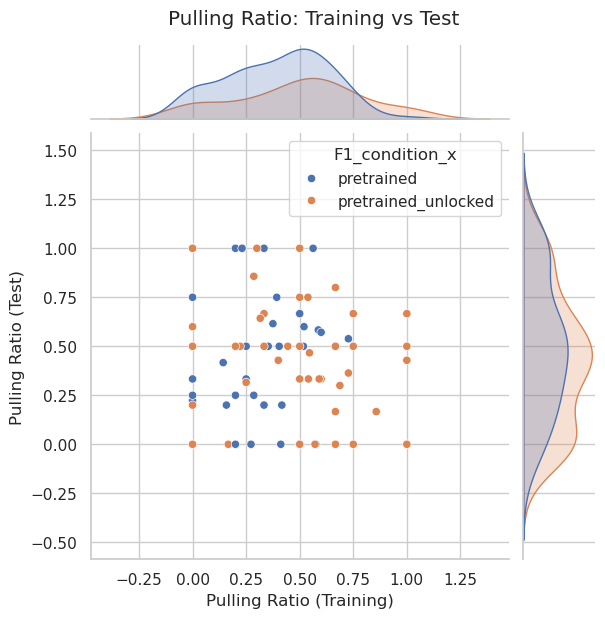

In [19]:
plt.figure(figsize=(20, 20))
# Create the jointplot
g = sns.jointplot(data=merged, x='pulling_ratio_x', y='pulling_ratio_y', hue='F1_condition_x')

# Set the title and labels using the JointGrid object
g.fig.suptitle('Pulling Ratio: Training vs Test', y=1.03)
g.set_axis_labels('Pulling Ratio (Training)', 'Pulling Ratio (Test)')

# Save the plot before showing it
plt.savefig(f"{plot_savepath}/Pulling_Ratio_Training_vs_Test.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Save the plot
plt.savefig(f"{plot_savepath}/Pulling_Ratio_Training_vs_Test.png")


<Figure size 640x480 with 0 Axes>

In [20]:
Data_Test = Data_metrics[(Data_metrics["ball_condition"] == "test")]

In [21]:
# Save the dataset to a csv file

Data_Test.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Summary_Test.csv")

In [22]:
# Let's get rid of the flies that never exit the corridor, so for which exit_time is None

Data_metrics = Data_metrics[Data_metrics["exit_time"].notnull()]

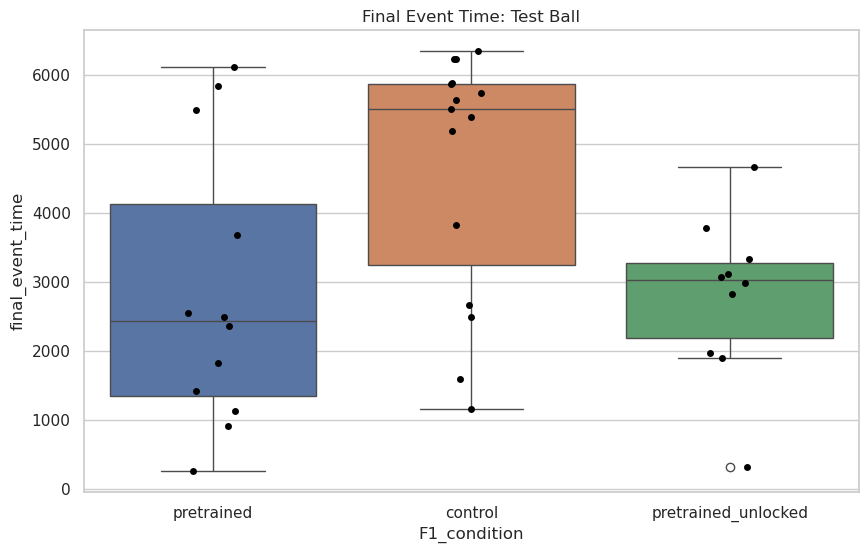

In [26]:
# Make a jitter boxplot of first significant time as function of F1 condition

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Create the boxplot
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='final_event_time', hue='F1_condition')

# Overlay the strip plot
sns.stripplot(data=Data_Test, x='F1_condition', y='final_event_time', color="black", dodge=False, jitter=True, ax=bp)

# Set the title
plt.title('Final Event Time: Test Ball')

# Save the plot with bbox_inches='tight' to avoid cropping
plt.savefig(f"{plot_savepath}/Final_Event_Time_Test_Ball.png", bbox_inches='tight')

# Show the plot
plt.show()

In [34]:
# Here let's compute bootstrap confidence intervals for the mean of the max event time grouped by F1 condition

intervals = {}

for condition in Data_Test["F1_condition"].unique():
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    BS = Processing.draw_bs_ci(data=condition_data["final_event_time"].dropna(), func=np.mean, n_reps=1000)
    
    intervals[condition] = BS
    

# Compute effect size between pretrained and control BS

effect_size = Processing.compute_effect_size(intervals["control"], intervals["pretrained"])

effect_size


100%|██████████| 1000/1000 [00:00<00:00, 5843.55it/s]


(np.float64(1684.6863433908043),
 (np.float64(3647.9208908045966), np.float64(-278.5482040229881)))

In [ ]:
# Plot the confidence intervals

fig = plt.figure(figsize=(10, 6))

for condition in intervals.keys():
    
    plt.errorbar(x=condition, y=np.mean(intervals[condition]), yerr=np.std(intervals[condition]), fmt='o', label=condition)
    
plt.title('Final event time: Test Ball')

plt.savefig(f"{plot_savepath}/Final_Event_Time_Test_Ball_CI.png", bbox_inches='tight')

plt.show()

In [35]:
# Let's now transform these value in h:m:s format

import datetime

average_time = effect_size[0]

print(f"Average time difference between control and pretrained is: {datetime.timedelta(seconds=average_time)}")

interval_times = effect_size[1]

print(f"bootstrapped 95% confidence interval for the difference is: {datetime.timedelta(seconds=interval_times[1])} - {datetime.timedelta(seconds=interval_times[0])}")

Average time difference between control and pretrained is: 0:28:04.686343
bootstrapped 95% confidence interval for the difference is: -1 day, 23:55:21.451796 - 1:00:47.920891


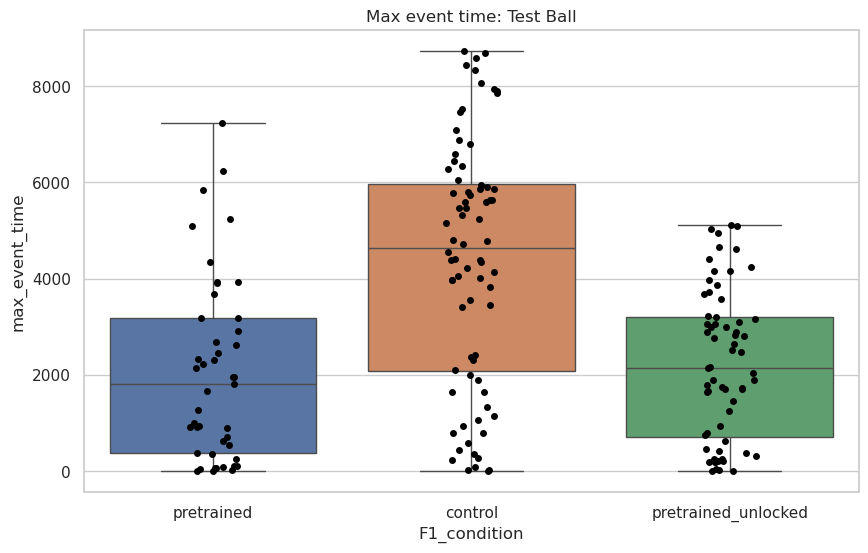

In [27]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='max_event_time', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='max_event_time', color = "black", dodge=False, jitter=True)

plt.title('Max event time: Test Ball')

plt.savefig(f"{plot_savepath}/Max_Event_Time_Test_Ball.png", bbox_inches='tight')

plt.show()

In [28]:
# Here let's compute bootstrap confidence intervals for the mean of the max event time grouped by F1 condition

intervals = {}

for condition in Data_Test["F1_condition"].unique():
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    BS = Processing.draw_bs_ci(data=condition_data["max_event_time"].dropna(), func=np.mean, n_reps=1000)
    
    intervals[condition] = BS
    
    


100%|██████████| 1000/1000 [00:00<00:00, 16340.72it/s]


In [29]:
intervals

{'pretrained': array([1510.4851341, 2629.4698659]),
 'control': array([3802.73808984, 4937.07497731]),
 'pretrained_unlocked': array([1849.72566002, 2596.55522629])}

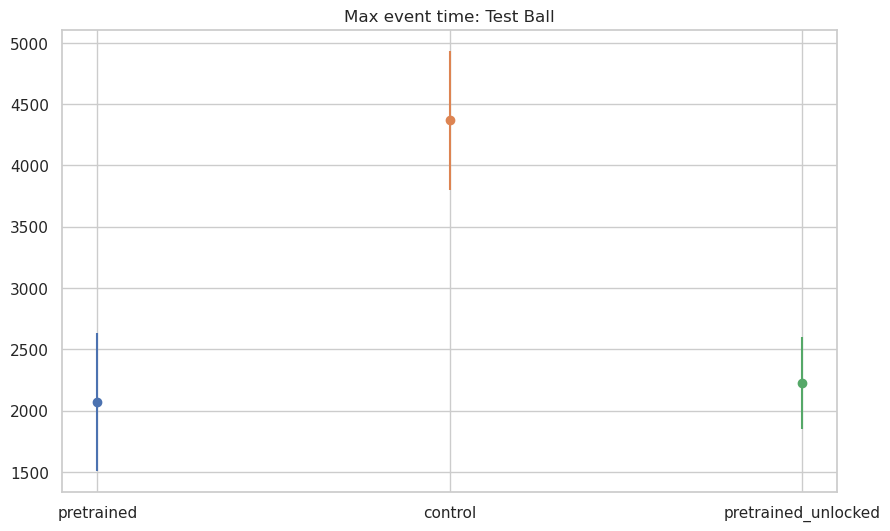

In [31]:
# Plot the confidence intervals

fig = plt.figure(figsize=(10, 6))

for condition in intervals.keys():
    
    plt.errorbar(x=condition, y=np.mean(intervals[condition]), yerr=np.std(intervals[condition]), fmt='o', label=condition)
    
plt.title('Max event time: Test Ball')

plt.savefig(f"{plot_savepath}/Max_Event_Time_Test_Ball_CI.png", bbox_inches='tight')

plt.show()

In [148]:
importlib.reload(Processing)

<module 'utils_behavior.Processing' from '/home/durrieu/utils_behavior/utils_behavior/Processing.py'>

In [32]:
# Compute effect size between pretrained and control BS

effect_size = Processing.compute_effect_size(intervals["control"], intervals["pretrained"])

effect_size

(np.float64(2299.9290335753167),
 (np.float64(3426.5898432143554), np.float64(1173.268223936277)))

In [33]:
# Let's now transform these value in h:m:s format

import datetime

average_time = effect_size[0]

print(f"Average time difference between control and pretrained is: {datetime.timedelta(seconds=average_time)}")

interval_times = effect_size[1]

print(f"bootstrapped 95% confidence interval for the difference is: {datetime.timedelta(seconds=interval_times[1])} - {datetime.timedelta(seconds=interval_times[0])}")



Average time difference between control and pretrained is: 0:38:19.929034
bootstrapped 95% confidence interval for the difference is: 0:19:33.268224 - 0:57:06.589843


In [134]:
Data_Test.columns

Index(['index', 'nb_events', 'max_event', 'max_event_time', 'max_distance',
       'final_event', 'final_event_time', 'nb_significant_events',
       'significant_ratio', 'first_significant_event',
       'first_significant_event_time', 'aha_moment', 'aha_moment_time',
       'insight_effect', 'cumulated_breaks_duration', 'pushed', 'pulled',
       'pulling_ratio', 'success_direction', 'interaction_proportion',
       'distance_moved', 'exit_time', 'direction_match', 'fly', 'flypath',
       'experiment', 'Nickname', 'Brain region', 'Date', 'Genotype', 'Period',
       'Peak', 'Orientation', 'Pretraining', 'Unlocked', '', 'F1_condition',
       'ball_condition', 'FeedingState', 'Light', 'Crossing', 'Balltype',
       'EndChamber'],
      dtype='object')

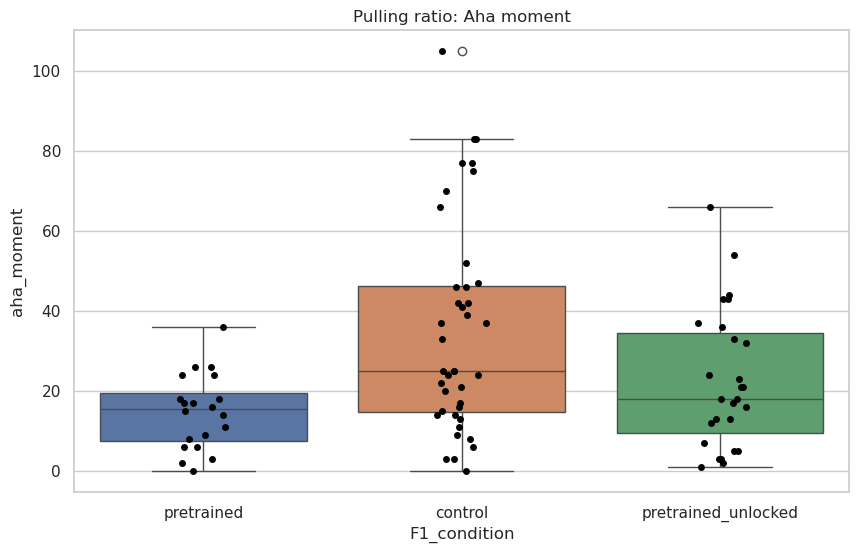

In [ ]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='aha_moment', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='aha_moment', color = "black", dodge=False, jitter=True)

plt.title('Pulling ratio: Aha moment')

plt.savefig(f"{plot_savepath}/Aha_Test_Ball.png", bbox_inches='tight')

plt.show()

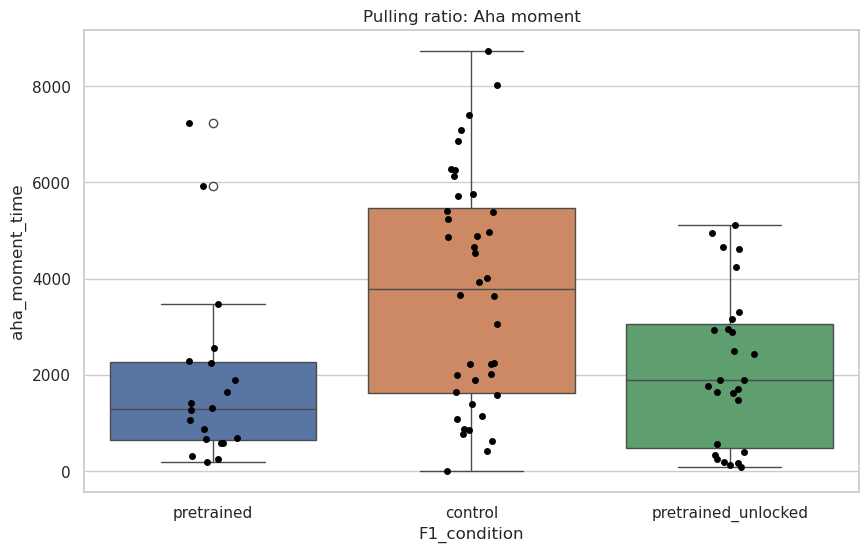

In [139]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='aha_moment_time', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='aha_moment_time', color = "black", dodge=False, jitter=True)

plt.title('Pulling ratio: Aha moment')

plt.savefig(f"{plot_savepath}/Aha_Test_Ball_time.png", bbox_inches='tight')

plt.show()

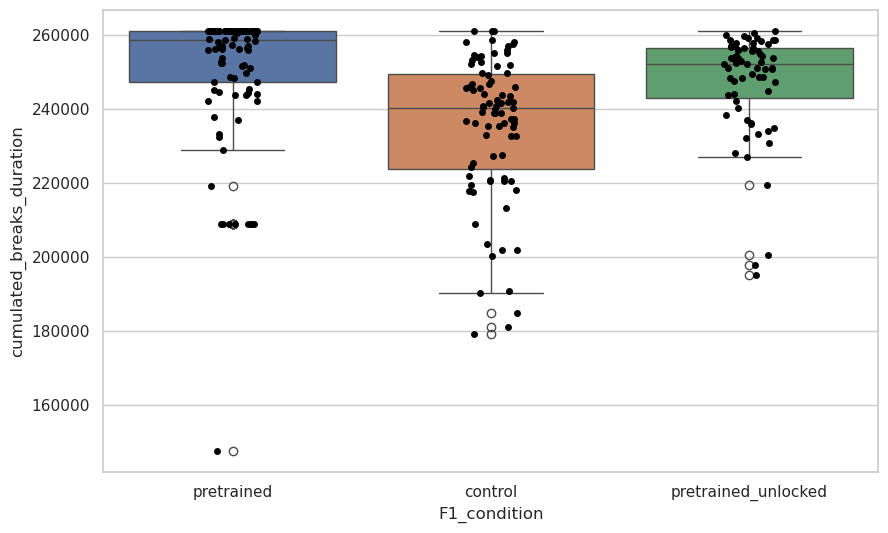

In [147]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='cumulated_breaks_duration', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='cumulated_breaks_duration', color = "black", dodge=False, jitter=True)

#plt.title('Pulling ratio: Aha moment')

#plt.savefig(f"{plot_savepath}/Adjusted_NbEvents.png", bbox_inches='tight')

plt.show()

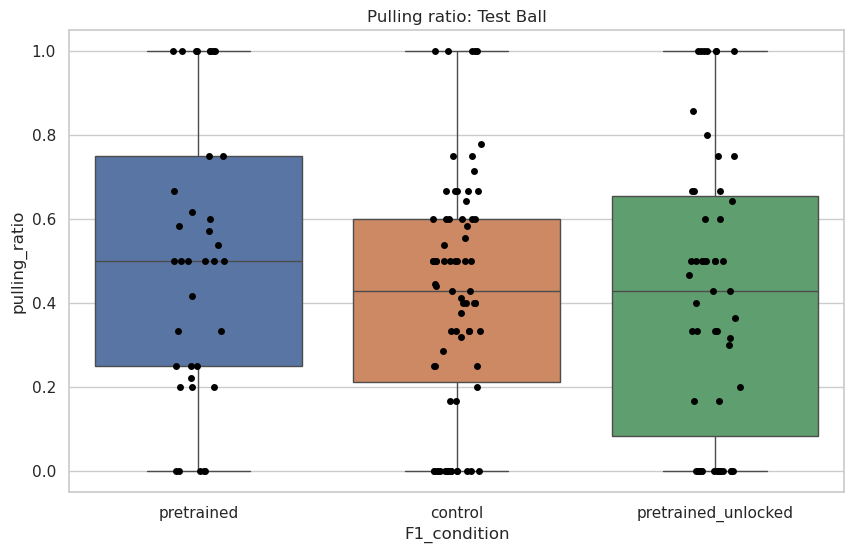

In [49]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
bp = sns.boxplot(data=Data_Test, x='F1_condition', y='pulling_ratio', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='pulling_ratio', color = "black", dodge=False, jitter=True)

plt.title('Pulling ratio: Test Ball')

plt.savefig(f"{plot_savepath}/Pulling_Ratio_Test_Ball.png", bbox_inches='tight')

plt.show()

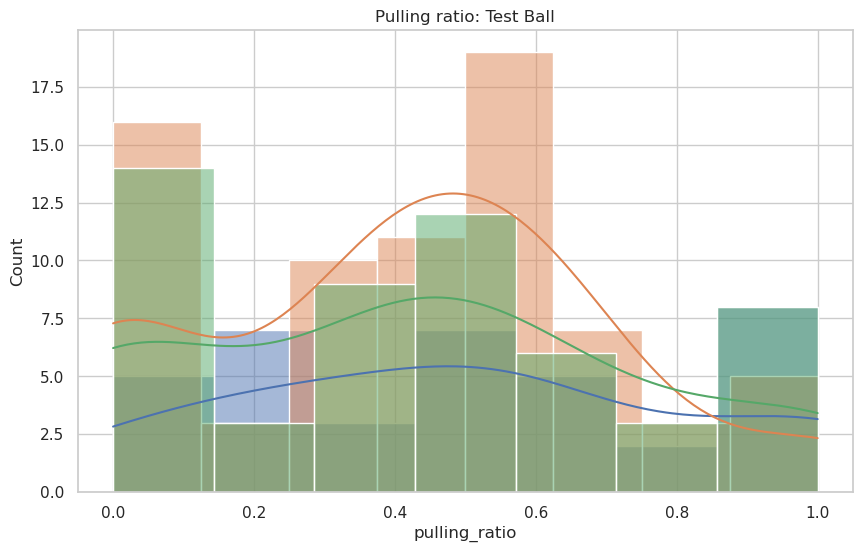

In [47]:
# Let's make histograms of the pulling ratio for each F1 condition

plt.figure(figsize=(10, 6))

for condition in Data_Test["F1_condition"].unique():
    
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    sns.histplot(data=condition_data, x='pulling_ratio', kde=True, label=condition)
    
plt.title('Pulling ratio: Test Ball')

plt.show()

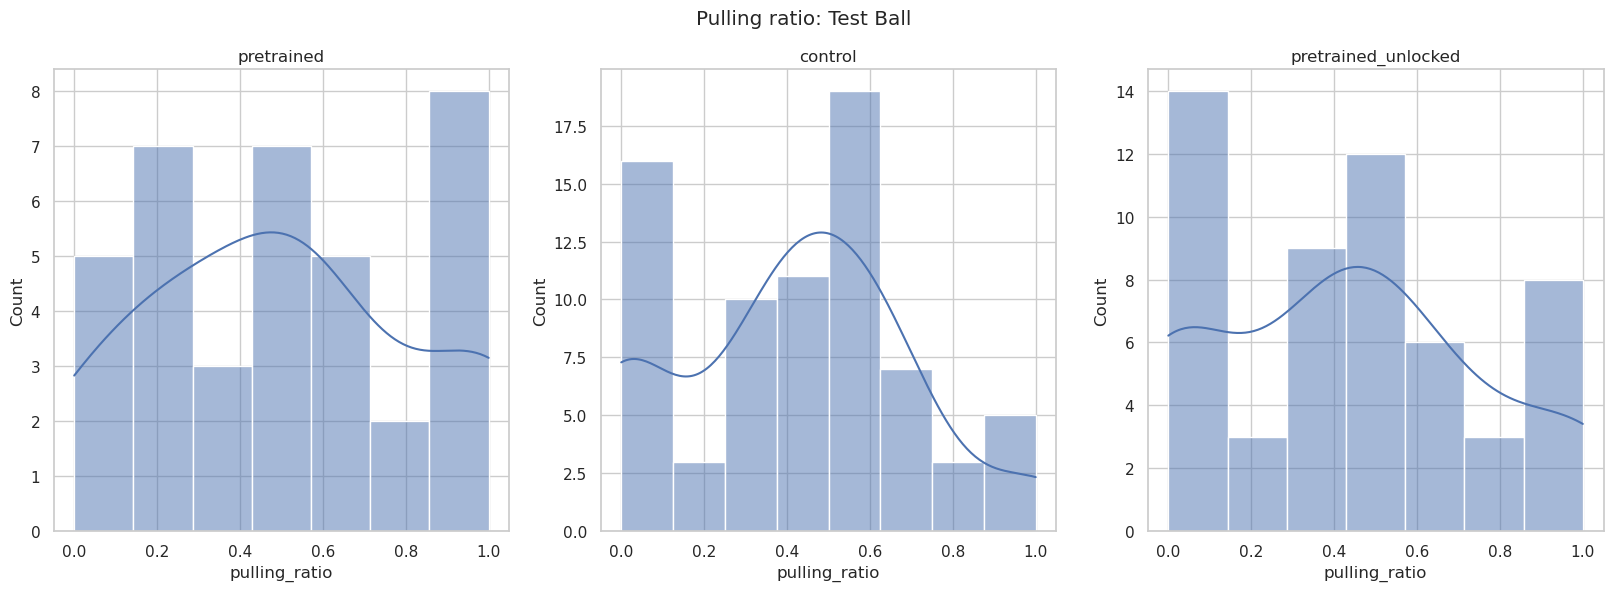

In [48]:
# Now let's make them in 3 different subplots

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, condition in enumerate(Data_Test["F1_condition"].unique()):
    
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    sns.histplot(data=condition_data, x='pulling_ratio', kde=True, label=condition, ax=axs[i])
    
    axs[i].set_title(condition)
    
plt.suptitle('Pulling ratio: Test Ball')

plt.show()

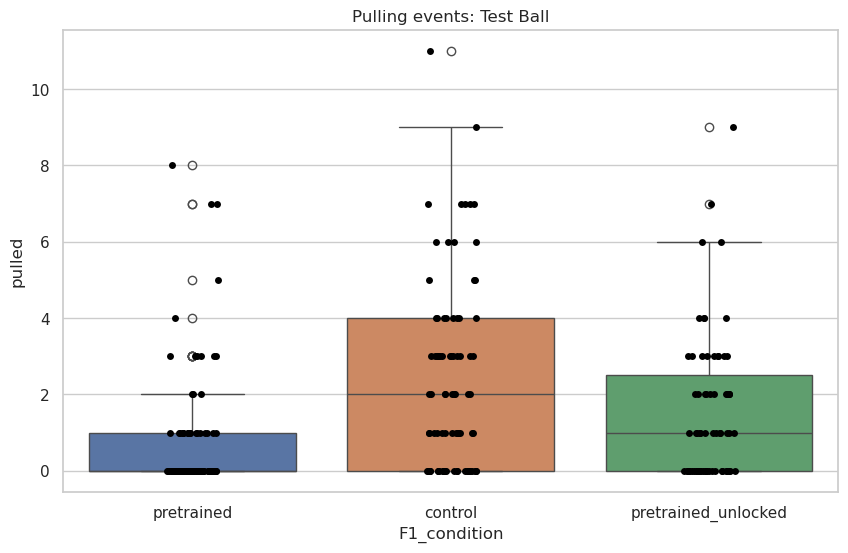

In [152]:
# Make a jitter boxplot of first significant time as function of F1 condition

plt.figure(figsize=(10, 6))
sns.boxplot(data=Data_Test, x='F1_condition', y='pulled', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='pulled', color = "black", dodge=False, jitter=True)

plt.title('Pulling events: Test Ball')

plt.show()

Text(0.5, 1.0, 'Pushing events: Test Ball')

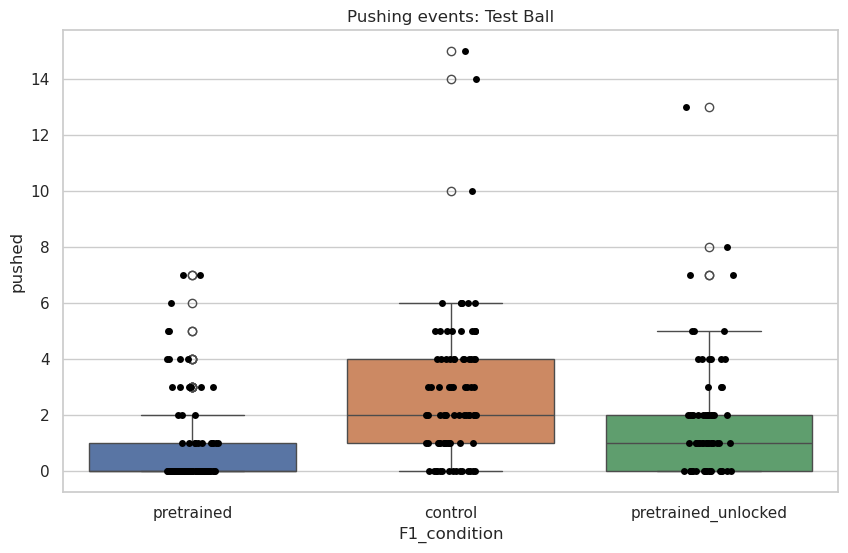

In [153]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=Data_Test, x='F1_condition', y='pushed', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='pushed', color = "black", dodge=False, jitter=True)

plt.title('Pushing events: Test Ball')


Text(0.5, 1.0, 'max_distance: Test Ball')

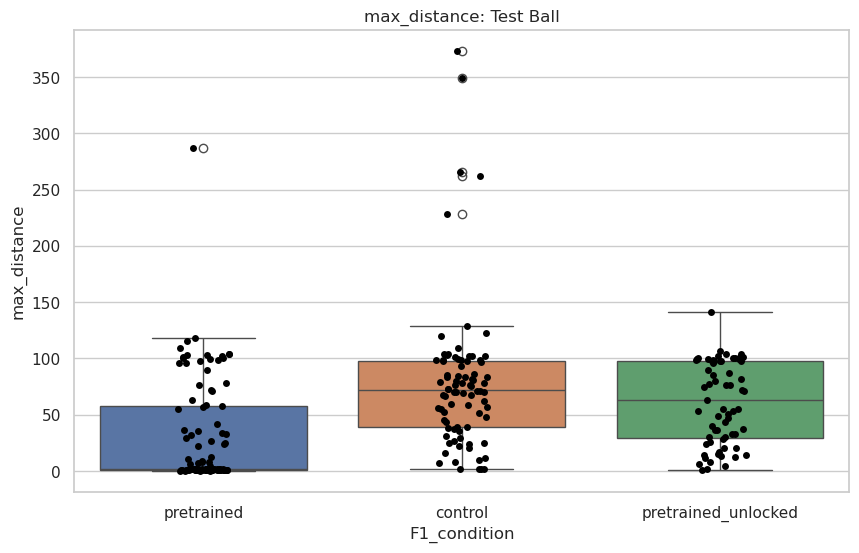

In [154]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=Data_Test, x='F1_condition', y='max_distance', hue='F1_condition')
sns.stripplot(data=Data_Test, x='F1_condition', y='max_distance', color = "black", dodge=False, jitter=True)

plt.title('max_distance: Test Ball')

Counter intuitively, the max distance the ball was moved for pretrained is lower

In [155]:
# Get bootstrap confidence intervals for the mean of the max distance

intervals = {}

for condition in Data_Test["F1_condition"].unique():
    condition_data = Data_Test[Data_Test["F1_condition"] == condition]
    
    BS = Processing.draw_bs_ci(data=condition_data["max_distance"].dropna(), func=np.mean, n_reps=1000)
    
    intervals[condition] = BS

100%|██████████| 1000/1000 [00:00<00:00, 12571.50it/s]


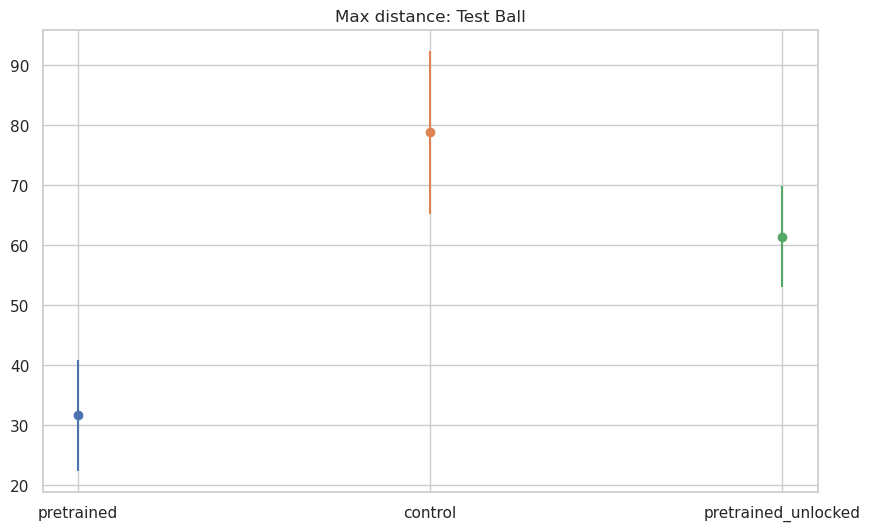

In [156]:
# Plot the confidence intervals

plt.figure(figsize=(10, 6))

for condition in intervals.keys():
        
        plt.errorbar(x=condition, y=np.mean(intervals[condition]), yerr=np.std(intervals[condition]), fmt='o', label=condition)
        
plt.title('Max distance: Test Ball')

plt.show()

In [157]:
# Compute effect size between pretrained and control BS

effect_size = Processing.compute_effect_size(intervals["control"], intervals["pretrained"])

effect_size

(np.float64(47.195092050162955),
 (np.float64(69.974530811952), np.float64(24.415653288373917)))

In [100]:
# Get how many flies are in each success_direction category, grouped by F1 condition

Data_Test.groupby(["F1_condition", "success_direction"]).size()

F1_condition         success_direction
control              both                  2
                     pull                 33
                     push                 35
pretrained           both                  1
                     pull                 14
                     push                 21
pretrained_unlocked  both                  3
                     pull                 20
                     push                 29
dtype: int64

Interestingly, there are very little groups that both push and pull the ball significantly. Seems to be one way or the other. 

There could be atleast 2 reasons for that: 

1) The flies have different strategies and stick to them

2) The way the ball looks when it has already been pushed or pulled once is leading to more of the same behavior (some kind of stigmery)

One way to check this is to verify what are the prefered behaviors for the first ball for pretrained

In [101]:
# For each fly, make a new column that is "match" if the success_direction is the same according for both ball conditions or "different" if it is different

Data_Test.groupby(["F1_condition", "direction_match"]).size()

F1_condition         direction_match
control              different          29
                     match               4
                     partial_match       1
pretrained           different          44
                     match              13
                     partial_match      41
pretrained_unlocked  different           6
                     match               8
                     partial_match      53
dtype: int64

When only considering strictly different condiditions (ignoring "both" as being push AND pull), I get: 
F1_condition         direction_match
pretrained           different          85
                     match              13
pretrained_unlocked  different          59
                     match               8


If I consider both as partial match, I get: 
F1_condition         direction_match
pretrained           different          44
                     match              13
                     partial_match      41
pretrained_unlocked  different           6
                     match               8
                     partial_match      53


so pretrained have 13 / 98 matches, if counting partial matches as well we get : 54 / 98 (half)
pretrained_unlocked have 8 / 67 match, if counting the partial matches: 61/67

Conclusion: for pretrained_unlocked they probably have much more "both" in the beginning, so that bumps up the partial matches

In [102]:
# Let's compare success_direction for training and test ball

Data_Training.groupby(["F1_condition", "success_direction"]).size()

F1_condition         success_direction
pretrained           both                 42
                     pull                 20
                     push                 34
pretrained_unlocked  both                 54
                     push                 13
dtype: int64

Here we have 34 / 96 push, goes up to 76 / 96 if we include both. There's quite a lot of pull as well

<Axes: xlabel='F1_condition', ylabel='exit_time'>

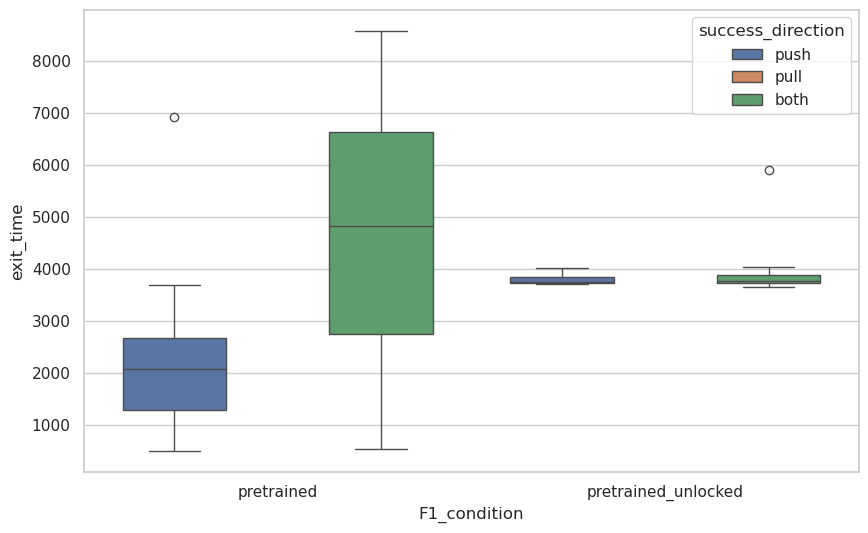

In [135]:
# For pretrained flies, compare fly exit time according to success_direction

plt.figure(figsize=(10, 6))

sns.boxplot(data=Data_Training, x='F1_condition', y='exit_time', hue='success_direction')

As expected, the 20 pull I see for pretrained are the flies that didn't exit (None time) and flies that didn't show pulling (push condition) exited earlier compared to the ones that pulled atleast once. 

> What if we remove the fail flies from the dataset? What will be the consequence?

In [136]:
Clean_Test = Data_Test.dropna(subset=["exit_time"])

Clean_Test.groupby(["F1_condition", "success_direction"]).size()

F1_condition         success_direction
control              both                  2
                     pull                 33
                     push                 35
pretrained           both                  1
                     pull                 14
                     push                 21
pretrained_unlocked  both                  3
                     pull                 20
                     push                 29
dtype: int64

In [138]:
29/51

0.5686274509803921

Now we have for pretrained a majority of pushers, 21 / 36 : 0.58

for pretrained unlocked, same as before as they all exited: 29 /51 : 0.57

Comparable.

In [139]:
Clean_Test.groupby(["F1_condition", "direction_match"]).size()

F1_condition         direction_match
control              different          29
                     match               4
                     partial_match       1
pretrained           different          12
                     match              11
                     partial_match      23
pretrained_unlocked  different           6
                     match               8
                     partial_match      52
dtype: int64

Now we get 11/46, with partial match : 34 / 46 : majority are matching.

pretrained unlocked have almost only partial match, didn't change.

In [ ]:
importlib.reload(Ballpushing_utils)

<module 'utils_behavior.Ballpushing_utils' from '/home/durrieu/utils_behavior/utils_behavior/Ballpushing_utils.py'>

In [37]:
Data_F1 = Ballpushing_utils.Dataset(Experiments)

In [38]:
# Generate the checkpoints dataset

Data_Checkpoints = Data_F1.generate_dataset("F1_checkpoints")

Fly 240924_F1_3mm_ends_Videos_Checked_arena2_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena7_Right never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena7_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena6_Right never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena6_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena8_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena4_Left never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena9_Right never exits the corridor
Fly 240924_F1_3mm_ends_Videos_Checked_arena9_Left never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena6_Right never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena6_Left never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena8_Left never exits the corridor
Fly 240919_F1_3mm_ends_Videos_Checked_arena3_Right never exits the corridor
Fly 240919_F1_3mm_en

In [39]:
# Get number of unique flies

Data_Checkpoints["fly"].nunique()

193

In [ ]:
Data_Checkpoints

,index,fly_exit_time,distance,adjusted_time,fly,flypath,experiment,Nickname,Brain region,Date,...,Pretraining,Unlocked,,F1_condition,success_direction,FeedingState,Light,Crossing,Balltype,EndChamber
0,0,6929.344828,10,11.793103,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,y,nn,,pretrained,None,NaN,NaN,NaN,NaN,NaN
1,1,6929.344828,25,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,y,nn,,pretrained,None,NaN,NaN,NaN,NaN,NaN
2,2,6929.344828,35,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,y,nn,,pretrained,None,NaN,NaN,NaN,NaN,NaN
3,3,6929.344828,50,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,y,nn,,pretrained,None,NaN,NaN,NaN,NaN,NaN
4,4,6929.344828,60,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,y,nn,,pretrained,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,3,798.172414,50,1730.655172,240809_F1_3mm_ends_Videos_Checked_arena9_Left,/mnt/upramdya_data/MD/F1_Tracks/Videos/240809_...,240809_F1_3mm_ends_Videos_Checked,PR,Control,240809,...,n,nn,NaN,control,pull,starved_noWater,on,NaN,NaN,3mm
1540,4,798.172414,60,1832.689655,240809_F1_3mm_ends_Videos_Checked_arena9_Left,/mnt/upramdya_data/MD/F1_Tracks/Videos/240809_...,240809_F1_3mm_ends_Videos_Checked,PR,Control,240809,...,n,nn,NaN,control,pull,starved_noWater,on,NaN,NaN,3mm
1541,5,798.172414,75,2018.586207,240809_F1_3mm_ends_Videos_Checked_arena9_Left,/mnt/upramdya_data/MD/F1_Tracks/Videos/240809_...,240809_F1_3mm_ends_Videos_Checked,PR,Control,240809,...,n,nn,NaN,control,pull,starved_noWater,on,NaN,NaN,3mm
1542,6,798.172414,90,2023.068966,240809_F1_3mm_ends_Videos_Checked_arena9_Left,/mnt/upramdya_data/MD/F1_Tracks/Videos/240809_...,240809_F1_3mm_ends_Videos_Checked,PR,Control,240809,...,n,nn,NaN,control,pull,starved_noWater,on,NaN,NaN,3mm


In [41]:
# Order the F1_conditions to be pretrained, control, pretrained_unlocked

Data_Checkpoints["F1_condition"] = pd.Categorical(
    Data_Checkpoints["F1_condition"],
    categories=["pretrained", "control", "pretrained_unlocked"],
    ordered=True,
)

In [42]:
# Save as csv

Data_Checkpoints.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241128_F1_Checkpoints.csv")

In [ ]:
#Data_Checkpoints["adjusted_time"] = Data_Checkpoints["adjusted_time"] - Data_Checkpoints["fly_exit_time"]

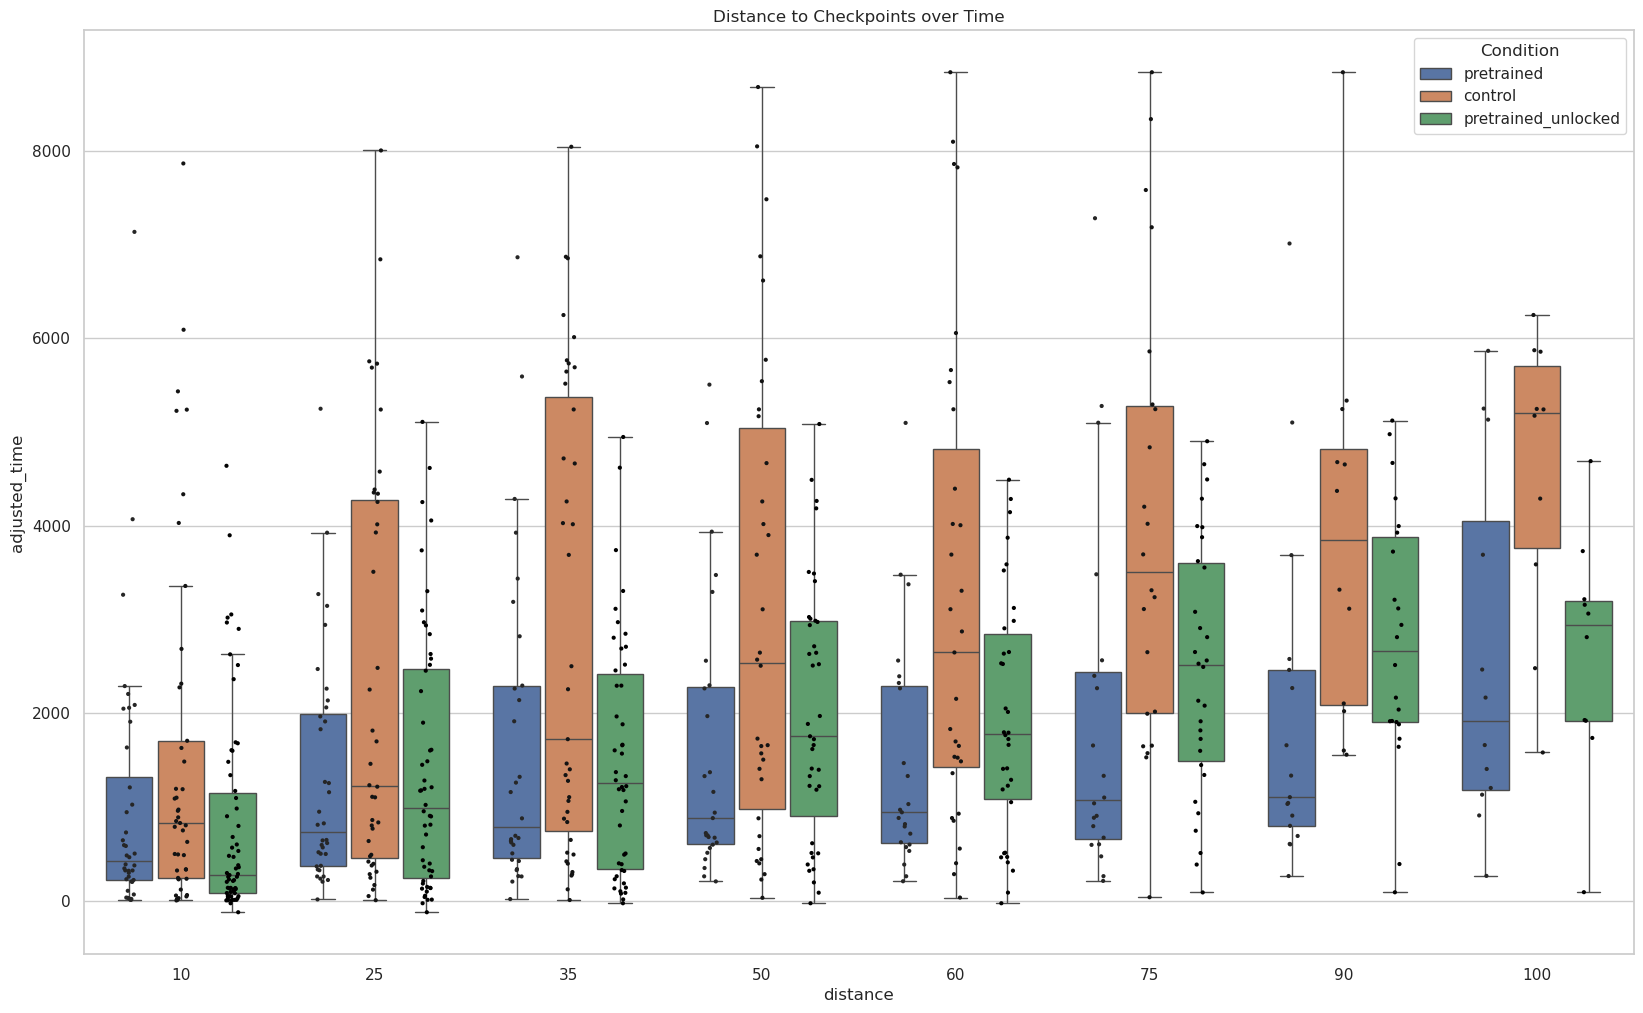

In [43]:
# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Create the boxplot with larger boxes
jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints, gap = 0.1, fliersize=0) 

# Overlay the strip plot with jittered points
jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints, dodge=True, jitter=0.1, size=3)

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title
jitterbox.set_title("Distance to Checkpoints over Time")

plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints.png", bbox_inches='tight')

plt.show()

TypeError: can only concatenate str (not "float") to str

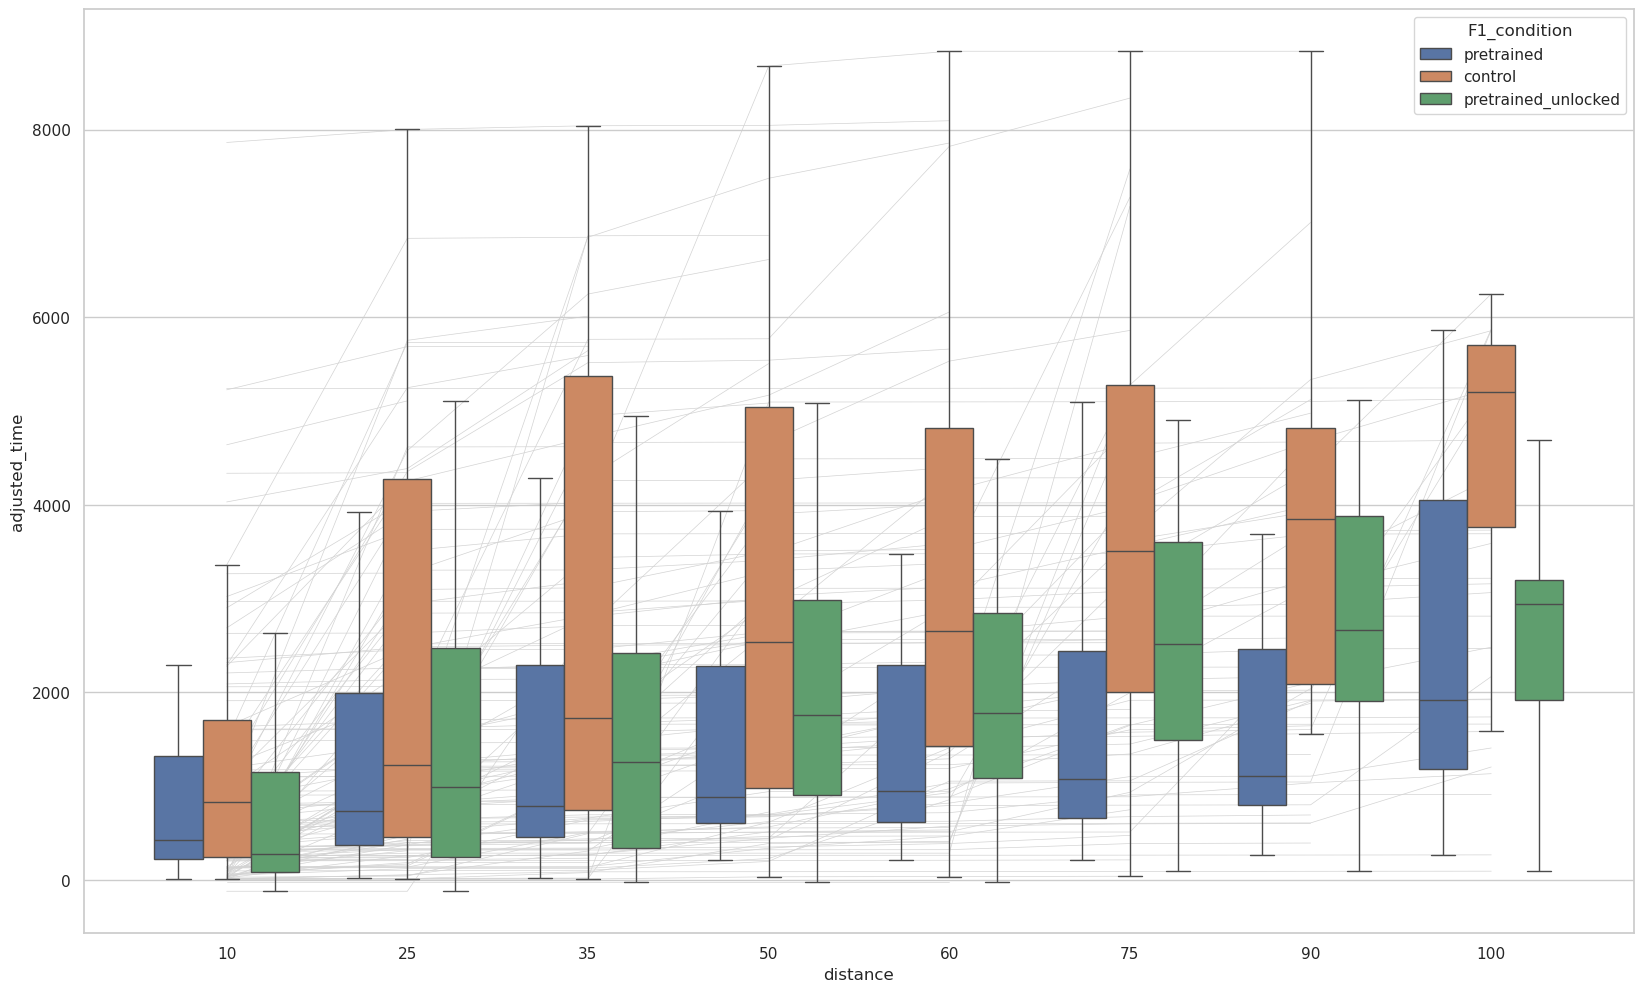

In [ ]:
# Create the boxplot with larger boxes
jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints, fliersize=0)

# Add light gray lines for each individual
for name, group in Data_Checkpoints.groupby("fly"):
    plt.plot(group["distance"], group["adjusted_time"], color="lightgray", linewidth=0.5, zorder=0)


# Overlay the strip plot with jittered points
sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints, dodge=True, jitter=0.1, size=3, ax=jitterbox)

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title
plt.title("Distance to Checkpoints over Time")

# Save the plot with bbox_inches='tight' to avoid cropping
#plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints.png", bbox_inches='tight')

# Show the plot
plt.show()

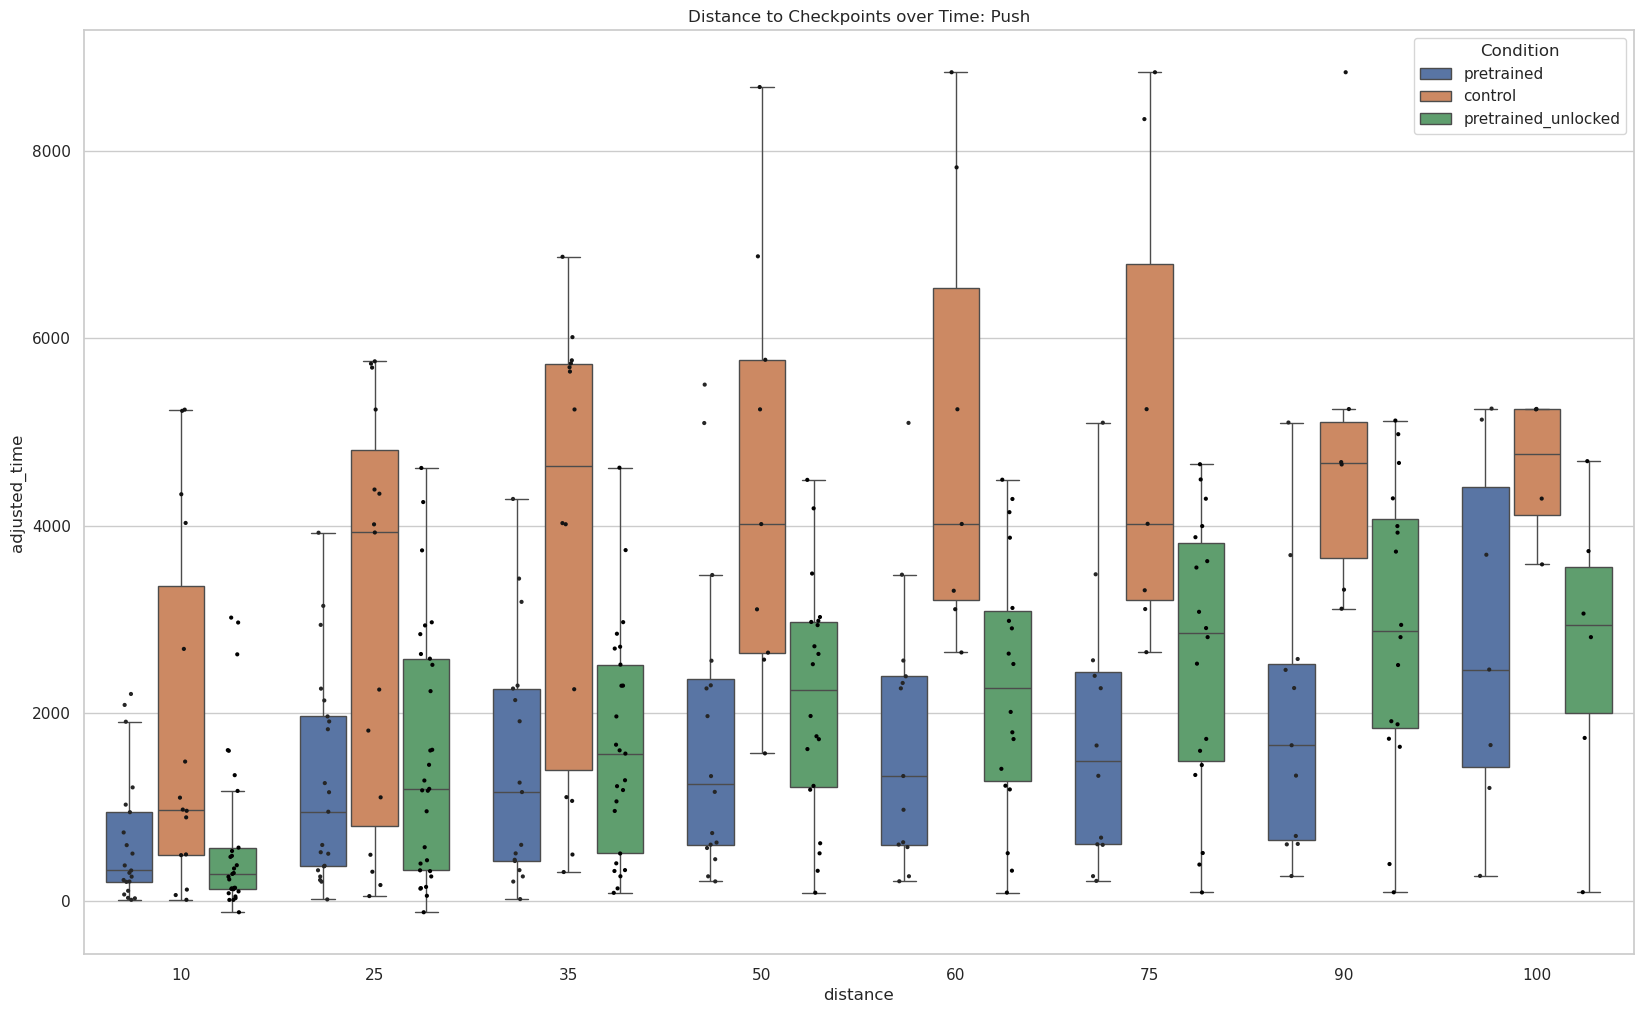

In [44]:
# Now do the same but split it between flies for which Data_Checkpoints["success_direction"] == "push" and Data_Checkpoints["success_direction"] == "pull"

Data_Checkpoints_push = Data_Checkpoints[Data_Checkpoints["success_direction"] == "push"]

Data_Checkpoints_pull = Data_Checkpoints[Data_Checkpoints["success_direction"] == "pull"]

Data_Checkpoints_both = Data_Checkpoints[Data_Checkpoints["success_direction"] == "both"]

# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Create the boxplot with larger boxes

jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints_push, gap = 0.1, fliersize=0)

# Overlay the strip plot with jittered points

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints_push, dodge=True, jitter=0.1, size=3)

# Adjust the legend to avoid duplication

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title

jitterbox.set_title("Distance to Checkpoints over Time: Push")

plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints_Push.png", bbox_inches='tight')

plt.show()

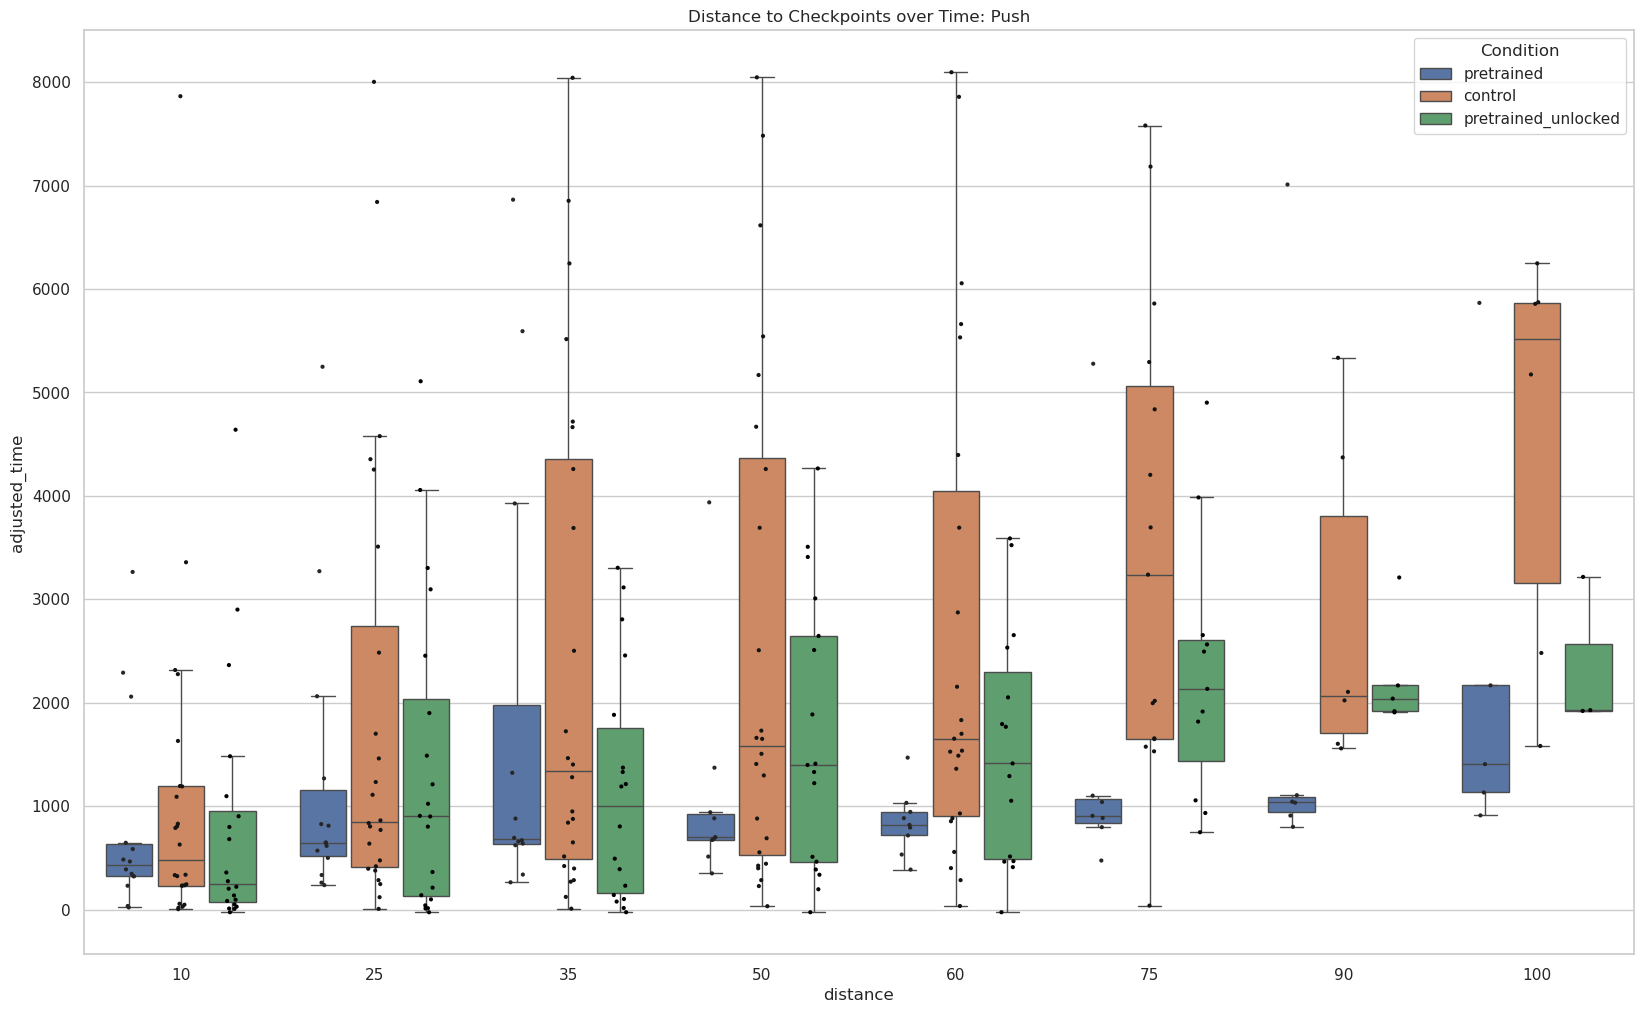

In [45]:



# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Create the boxplot with larger boxes

jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints_pull, gap = 0.1, fliersize=0)

# Overlay the strip plot with jittered points

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color="black", data=Data_Checkpoints_pull, dodge=True, jitter=0.1, size=3)

# Adjust the legend to avoid duplication

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Condition")

# Set the title

jitterbox.set_title("Distance to Checkpoints over Time: Push")

plt.savefig(f"{plot_savepath}/Distance_to_Checkpoints_Pull.png", bbox_inches='tight')

plt.show()

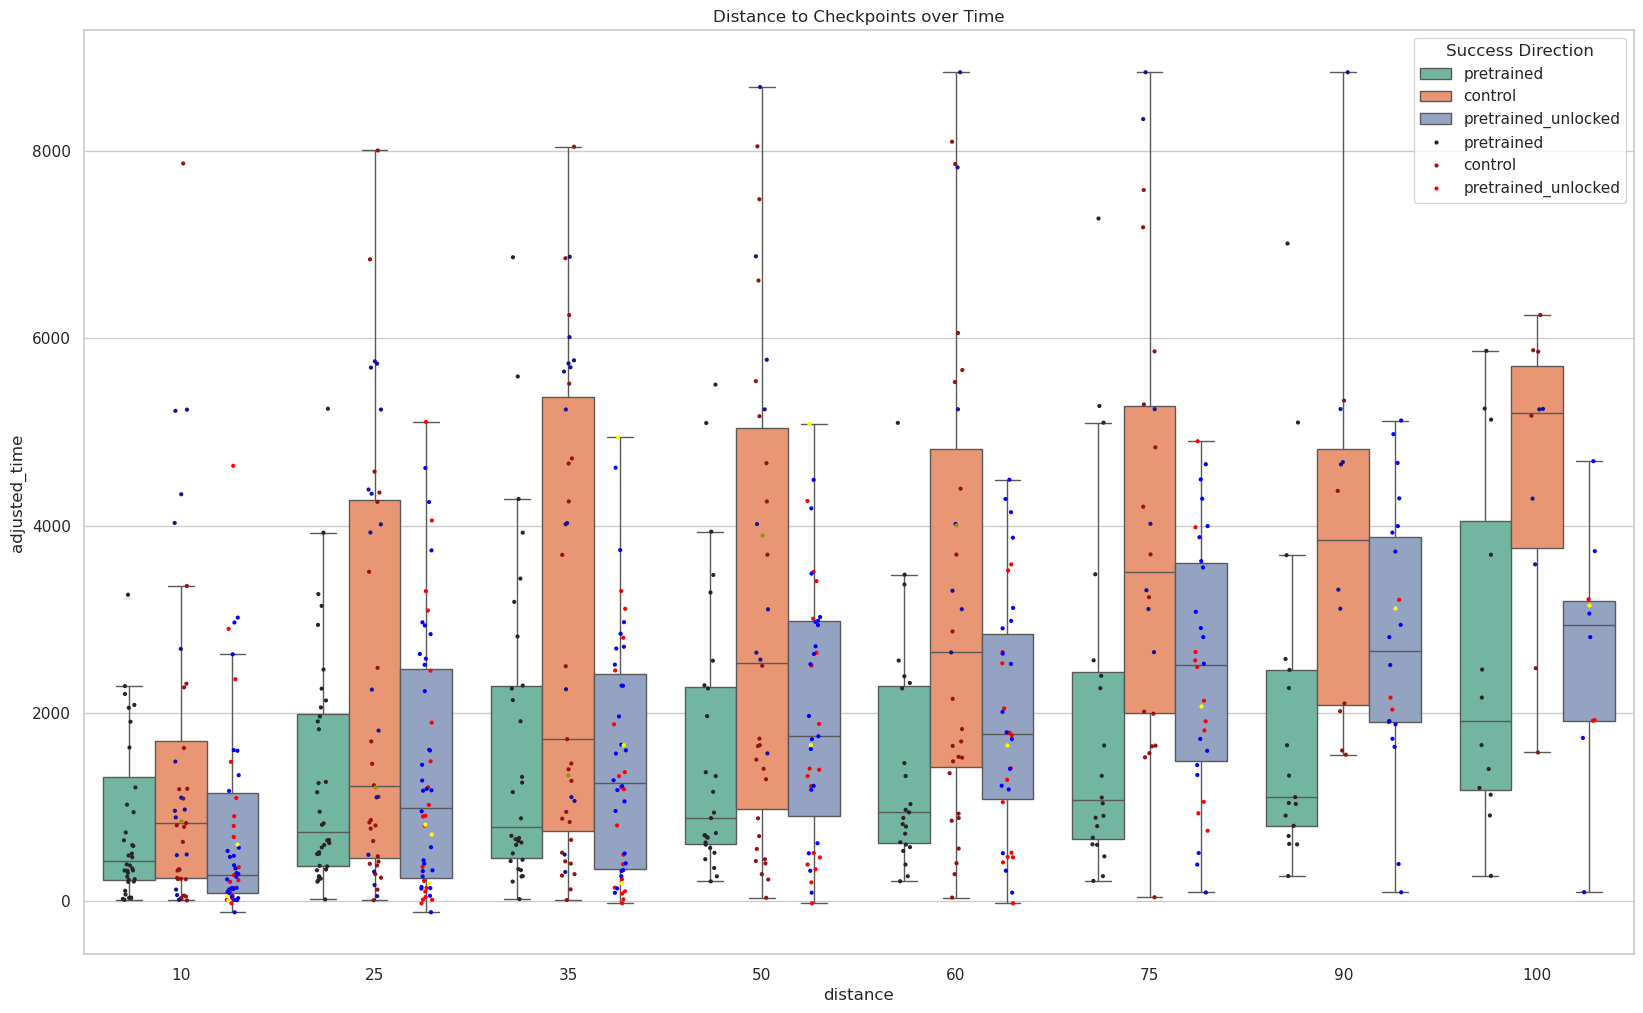

In [ ]:
# Now redo the initial plot but color the points by success direction

# Set the theme and style
sns.set_theme(rc={'figure.figsize':(20,12)})
sns.set_style("whitegrid")

# Define color palettes
boxplot_palette = "Set2"
stripplot_palette = {"push": "blue", "pull": "red", "both": "green", "none": "gray"}

# Create the boxplot with larger boxes
jitterbox = sns.boxplot(x="distance", y="adjusted_time", hue="F1_condition", data=Data_Checkpoints, palette=boxplot_palette, fliersize=0,)

# Overlay the strip plot with jittered points
jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color = "red", data=Data_Checkpoints_pull, dodge=True, jitter=0.1, size=3,)

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color = "blue", data=Data_Checkpoints_push, dodge=True, jitter=0.1, size=3,)

jitterbox = sns.stripplot(x="distance", y="adjusted_time", hue="F1_condition", color = "yellow", data=Data_Checkpoints_both, dodge=True, jitter=0.1, size=3,)

# Adjust the legend to avoid duplication
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2], title="Success Direction")

# Set the title
jitterbox.set_title("Distance to Checkpoints over Time")

plt.show()

In [35]:
# Update the 'pretraining' column based on 'F1_condition'
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained", "pretraining"] = "y"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained_unlocked", "pretraining"] = "y"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "control", "pretraining"] = "n"

# Update the 'unlocked' column based on 'F1_condition'
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained", "unlocked"] = "n"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "pretrained_unlocked", "unlocked"] = "y"
Data_Checkpoints.loc[Data_Checkpoints["F1_condition"] == "control", "unlocked"] = "n"

# Display the first few rows of the DataFrame
Data_Checkpoints.head()




,index,fly_exit_time,distance,adjusted_time,fly,flypath,experiment,Nickname,Brain region,Date,...,,F1_condition,success_direction,FeedingState,Light,Crossing,Balltype,EndChamber,pretraining,unlocked
0,0,6929.344828,10,11.793103,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,,pretrained,None,NaN,NaN,NaN,NaN,NaN,y,n
1,1,6929.344828,25,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,,pretrained,None,NaN,NaN,NaN,NaN,NaN,y,n
2,2,6929.344828,35,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,,pretrained,None,NaN,NaN,NaN,NaN,NaN,y,n
3,3,6929.344828,50,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,,pretrained,None,NaN,NaN,NaN,NaN,NaN,y,n
4,4,6929.344828,60,NaN,240924_F1_3mm_ends_Videos_Checked_arena2_Right,/mnt/upramdya_data/MD/F1_Tracks/Videos/240924_...,240924_F1_3mm_ends_Videos_Checked,PR,Control,240924,...,,pretrained,None,NaN,NaN,NaN,NaN,NaN,y,n


In [36]:
# Save again

Data_Checkpoints.to_csv("/mnt/upramdya_data/MD/F1_Tracks/Datasets/241114_F1_Checkpoints.csv")